In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
from pathlib import Path
# Try common filenames first, then any CSV inside the local `data/` folder
candidates = [
    Path('data/sri_lanka_dengue_extended.csv'),
    Path('data/sri_lanka_dengue_sample.csv'),
    Path('sri_lanka_dengue_sample.csv'),
    Path('data/sri_lanka_dengue.csv')
]
fn_path = None
for p in candidates:
    if p.exists():
        fn_path = p
        break
# If not found, scan the data/ directory for any CSV
if fn_path is None:
    data_dir = Path('data')
    if data_dir.exists():
        csvs = list(data_dir.glob('*.csv'))
        if csvs:
            fn_path = csvs[0]
if fn_path is None:
    raise FileNotFoundError('No dataset found. Place the CSV in the data/ folder or set `fn` to the correct path.')
fn = str(fn_path)
print('Using dataset file:', fn)
df = pd.read_csv(fn)
df = df.sort_values(['District', 'Year', 'Month']).reset_index(drop=True)
print('Data shape:', df.shape)
df.head()

Using dataset file: data\sri_lanka_dengue_sample.csv
Data shape: (2100, 9)


,District,Year,Month,Rainfall_mm,Temperature_C,Humidity_pct,Population_Density,Dengue_Cases,Outbreak
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0


In [3]:
df.isnull().sum()

District              0
Year                  0
Month                 0
Rainfall_mm           0
Temperature_C         0
Humidity_pct          0
Population_Density    0
Dengue_Cases          0
Outbreak              0
dtype: int64

In [4]:
df.head()

,District,Year,Month,Rainfall_mm,Temperature_C,Humidity_pct,Population_Density,Dengue_Cases,Outbreak
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0


In [5]:
# Basic dataset info
print('\nColumns:', df.columns.tolist())
print('\nSample statistics:\n', df.describe(include='all').T)


Columns: ['District', 'Year', 'Month', 'Rainfall_mm', 'Temperature_C', 'Humidity_pct', 'Population_Density', 'Dengue_Cases', 'Outbreak']

Sample statistics:
                      count unique     top freq        mean          std  \
District              2100     25  Ampara   84         NaN          NaN   
Year                2100.0    NaN     NaN  NaN      2021.0     2.000476   
Month               2100.0    NaN     NaN  NaN         6.5     3.452875   
Rainfall_mm         2100.0    NaN     NaN  NaN  196.729532    85.722293   
Temperature_C       2100.0    NaN     NaN  NaN   27.986501     3.453629   
Humidity_pct        2100.0    NaN     NaN  NaN   77.587601    10.394458   
Population_Density  2100.0    NaN     NaN  NaN  3626.05852  1909.343103   
Dengue_Cases        2100.0    NaN     NaN  NaN   20.902857      7.38566   
Outbreak            2100.0    NaN     NaN  NaN         0.0          0.0   

                           min          25%          50%         75%  \
District          

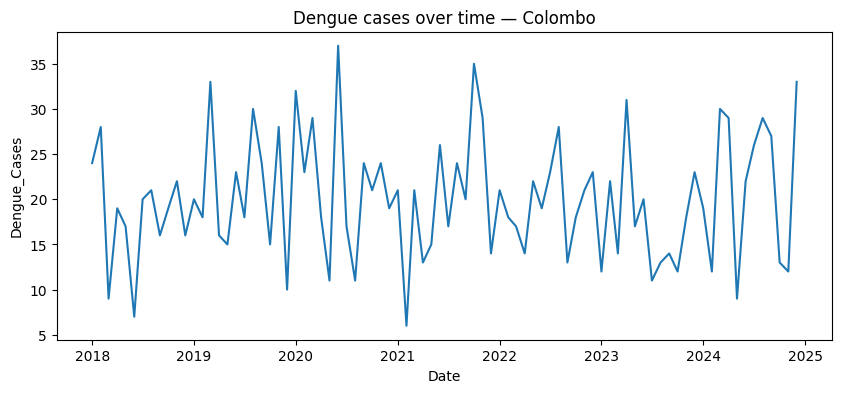

In [6]:
# create a monthly Date column from Year and Month, then plot using that datetime
sub = df[df['District'] == 'Colombo'].copy()
sub['Date'] = pd.to_datetime(dict(year=sub['Year'], month=sub['Month'], day=1))

plt.figure(figsize=(10,4))
sns.lineplot(data=sub, x='Date', y='Dengue_Cases')
plt.title('Dengue cases over time — Colombo')
plt.show()

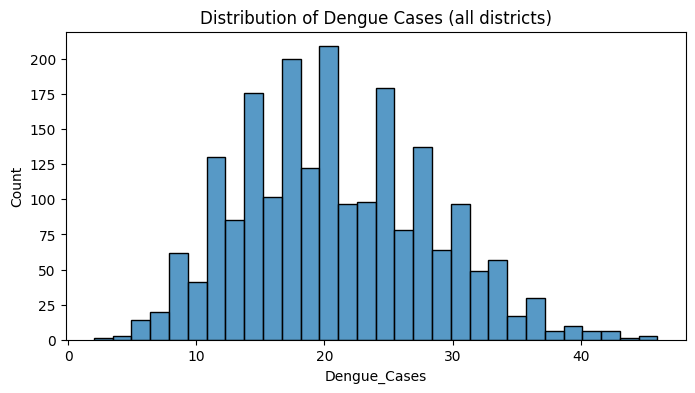

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df['Dengue_Cases'], bins=30, kde=False)
plt.title('Distribution of Dengue Cases (all districts)')
plt.show()

In [8]:
# feature engineering
df_fe = df.copy()
df_fe.columns = [c.lower() for c in df_fe.columns]


In [9]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0
5,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0
6,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0
7,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0
8,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0
9,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0


In [10]:
# Cases per 10k population (synthetic)
df_fe['cases_per_10k'] = df_fe['dengue_cases'] / (df_fe['population_density'] + 1) * 10000


In [11]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak,cases_per_10k
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0,37.066839
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0,120.569580
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0,373.639485
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0,83.554293
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0,46.588216
5,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0,49.660119
6,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0,30.894760
7,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0,34.760630
8,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0,100.443749
9,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0,105.470500


In [12]:
# Date features
# create a monthly datetime column from existing year and month (use first day of month)
df_fe['date'] = pd.to_datetime(dict(year=df_fe['year'], month=df_fe['month'], day=1))

# extract features from the datetime column
df_fe['month'] = df_fe['date'].dt.month
df_fe['year'] = df_fe['date'].dt.year
df_fe['week_of_year'] = df_fe['date'].dt.isocalendar().week.astype(int)

In [13]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak,cases_per_10k,date,week_of_year
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0,37.066839,2018-01-01,1
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0,120.569580,2018-02-01,5
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0,373.639485,2018-03-01,9
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0,83.554293,2018-04-01,13
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0,46.588216,2018-05-01,18
5,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0,49.660119,2018-06-01,22
6,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0,30.894760,2018-07-01,26
7,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0,34.760630,2018-08-01,31
8,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0,100.443749,2018-09-01,35
9,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0,105.470500,2018-10-01,40


In [14]:
# Lag features per district
lag_weeks = [1,2,3,4]
for lag in lag_weeks:
    df_fe[f'cases_lag_{lag}'] = df_fe.groupby('district')['dengue_cases'].shift(lag)
    df_fe[f'rainfall_lag_{lag}'] = df_fe.groupby('district')['rainfall_mm'].shift(lag)
    df_fe[f'temp_lag_{lag}'] = df_fe.groupby('district')['temperature_c'].shift(lag)

In [15]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak,cases_per_10k,...,temp_lag_1,cases_lag_2,rainfall_lag_2,temp_lag_2,cases_lag_3,rainfall_lag_3,temp_lag_3,cases_lag_4,rainfall_lag_4,temp_lag_4
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0,37.066839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0,120.569580,...,32.454947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0,373.639485,...,25.613074,15.0,140.958125,32.454947,NaN,NaN,NaN,NaN,NaN,NaN
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0,83.554293,...,28.209773,9.0,76.491685,25.613074,15.0,140.958125,32.454947,NaN,NaN,NaN
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0,46.588216,...,28.750918,22.0,166.444672,28.209773,9.0,76.491685,25.613074,15.0,140.958125,32.454947
5,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0,49.660119,...,25.383916,26.0,216.446937,28.750918,22.0,166.444672,28.209773,9.0,76.491685,25.613074
6,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0,30.894760,...,22.044697,16.0,81.242766,25.383916,26.0,216.446937,28.750918,22.0,166.444672,28.209773
7,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0,34.760630,...,23.166772,15.0,104.052805,22.044697,16.0,81.242766,25.383916,26.0,216.446937,28.750918
8,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0,100.443749,...,32.948957,19.0,243.737680,23.166772,15.0,104.052805,22.044697,16.0,81.242766,25.383916
9,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0,105.470500,...,25.143889,19.0,63.457883,32.948957,19.0,243.737680,23.166772,15.0,104.052805,22.044697


In [16]:
# Rolling mean past 4 weeks
df_fe['cases_roll4'] = df_fe.groupby('district')['dengue_cases'].shift(1).rolling(window=4, min_periods=1).mean().reset_index(0,drop=True)


In [17]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak,cases_per_10k,...,cases_lag_2,rainfall_lag_2,temp_lag_2,cases_lag_3,rainfall_lag_3,temp_lag_3,cases_lag_4,rainfall_lag_4,temp_lag_4,cases_roll4
0,Ampara,2018,1,140.958125,32.454947,84.095532,4045.743801,15,0,37.066839,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ampara,2018,2,76.491685,25.613074,70.412905,745.456941,9,0,120.569580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000
2,Ampara,2018,3,166.444672,28.209773,74.276718,587.802867,22,0,373.639485,...,15.0,140.958125,32.454947,NaN,NaN,NaN,NaN,NaN,NaN,12.000000
3,Ampara,2018,4,216.446937,28.750918,61.233725,3110.749158,26,0,83.554293,...,9.0,76.491685,25.613074,15.0,140.958125,32.454947,NaN,NaN,NaN,15.333333
4,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0,46.588216,...,22.0,166.444672,28.209773,9.0,76.491685,25.613074,15.0,140.958125,32.454947,18.000000
5,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0,49.660119,...,26.0,216.446937,28.750918,22.0,166.444672,28.209773,9.0,76.491685,25.613074,18.250000
6,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0,30.894760,...,16.0,81.242766,25.383916,26.0,216.446937,28.750918,22.0,166.444672,28.209773,19.750000
7,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0,34.760630,...,15.0,104.052805,22.044697,16.0,81.242766,25.383916,26.0,216.446937,28.750918,19.000000
8,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0,100.443749,...,19.0,243.737680,23.166772,15.0,104.052805,22.044697,16.0,81.242766,25.383916,17.250000
9,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0,105.470500,...,19.0,63.457883,32.948957,19.0,243.737680,23.166772,15.0,104.052805,22.044697,21.500000


In [18]:
# Drop remaining NA rows from lagging
df_fe = df_fe.dropna().reset_index(drop=True)
print('After feature engineering shape:', df_fe.shape)

After feature engineering shape: (2000, 25)


In [19]:
df_fe.head(10)

,district,year,month,rainfall_mm,temperature_c,humidity_pct,population_density,dengue_cases,outbreak,cases_per_10k,...,cases_lag_2,rainfall_lag_2,temp_lag_2,cases_lag_3,rainfall_lag_3,temp_lag_3,cases_lag_4,rainfall_lag_4,temp_lag_4,cases_roll4
0,Ampara,2018,5,81.242766,25.383916,66.942194,3433.344842,16,0,46.588216,...,22.0,166.444672,28.209773,9.0,76.491685,25.613074,15.0,140.958125,32.454947,18.00
1,Ampara,2018,6,104.052805,22.044697,71.481545,3019.532403,15,0,49.660119,...,26.0,216.446937,28.750918,22.0,166.444672,28.209773,9.0,76.491685,25.613074,18.25
2,Ampara,2018,7,243.737680,23.166772,62.593543,6148.910112,19,0,30.894760,...,16.0,81.242766,25.383916,26.0,216.446937,28.750918,22.0,166.444672,28.209773,19.75
3,Ampara,2018,8,63.457883,32.948957,70.991662,5464.953837,19,0,34.760630,...,15.0,104.052805,22.044697,16.0,81.242766,25.383916,26.0,216.446937,28.750918,19.00
4,Ampara,2018,9,301.900638,25.143889,91.930906,3284.420968,33,0,100.443749,...,19.0,243.737680,23.166772,15.0,104.052805,22.044697,16.0,81.242766,25.383916,17.25
5,Ampara,2018,10,239.417503,28.828926,93.105056,1895.264834,20,0,105.470500,...,19.0,63.457883,32.948957,19.0,243.737680,23.166772,15.0,104.052805,22.044697,21.50
6,Ampara,2018,11,187.904580,28.142872,72.552949,5053.477546,21,0,41.547321,...,33.0,301.900638,25.143889,19.0,63.457883,32.948957,19.0,243.737680,23.166772,22.75
7,Ampara,2018,12,87.212838,24.627101,78.417451,4928.208700,13,0,26.373401,...,20.0,239.417503,28.828926,33.0,301.900638,25.143889,19.0,63.457883,32.948957,23.25
8,Ampara,2019,1,182.070348,29.249241,70.003344,1134.476658,18,0,158.523734,...,21.0,187.904580,28.142872,20.0,239.417503,28.828926,33.0,301.900638,25.143889,21.75
9,Ampara,2019,2,133.114308,31.548602,65.092951,5851.811096,13,0,22.211549,...,13.0,87.212838,24.627101,21.0,187.904580,28.142872,20.0,239.417503,28.828926,18.00


In [20]:
# 5️⃣ Label creation: predict outbreak next week
if 'outbreak' not in df_fe.columns:
    raise ValueError('Dataset does not contain an outbreak column for label creation.')

df_fe['outbreak_next'] = df_fe.groupby('district')['outbreak'].shift(-1)
df_fe = df_fe.dropna(subset=['outbreak_next']).reset_index(drop=True)
df_fe['outbreak_next'] = df_fe['outbreak_next'].astype(int)
print('Label distribution (outbreak_next):')
print(df_fe['outbreak_next'].value_counts(normalize=True))


Label distribution (outbreak_next):
outbreak_next
0    1.0
Name: proportion, dtype: float64


In [21]:
# 6️⃣ Prepare features X and target y
feature_cols = [
    'cases_lag_1','cases_lag_2','cases_lag_3','cases_lag_4',
    'cases_roll4',
    'rainfall_lag_1','rainfall_lag_2','rainfall_lag_3','rainfall_lag_4',
    'temp_lag_1','temp_lag_2','temp_lag_3','temp_lag_4',
    'month','population_density'
]
feature_cols = [c for c in feature_cols if c in df_fe.columns]

X = df_fe[feature_cols].copy()
y = df_fe['outbreak_next'].copy()
print('Using features:', feature_cols)
print('X shape:', X.shape, 'y shape:', y.shape)

Using features: ['cases_lag_1', 'cases_lag_2', 'cases_lag_3', 'cases_lag_4', 'cases_roll4', 'rainfall_lag_1', 'rainfall_lag_2', 'rainfall_lag_3', 'rainfall_lag_4', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'month', 'population_density']
X shape: (1975, 15) y shape: (1975,)


In [22]:
# 7️⃣ Time-aware train/test split
years = sorted(df_fe['year'].unique())
if 2022 in years:
    train_idx = df_fe['year'] <= 2021
    test_idx = df_fe['year'] == 2022
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
else:
    split_point = int(len(df_fe)*0.7)
    X_train, y_train = X.iloc[:split_point], y.iloc[:split_point]
    X_test, y_test = X.iloc[split_point:], y.iloc[split_point:]

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (1100, 15) Test shape: (300, 15)


In [23]:
# 8️⃣ Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [27]:
# 9️⃣ RDA-like model: LDA with shrinkage + hyperparameter tuning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

param_grid = {'shrinkage': [0.0, 0.25, 0.5, 0.75, 1.0]}
tscv = TimeSeriesSplit(n_splits=5)
best_f1 = -1.0
best_shrinkage = None
best_model = None

# Convert y_train to numpy array to ensure proper indexing
y_train_np = y_train.values

# If training labels contain only a single class, LDA will fail.
unique_classes = np.unique(y_train_np)
if unique_classes.shape[0] <= 1:
    # Fallback: constant predictor (predict the single observed class)
    const_class = int(unique_classes[0])
    print(f"Only one class present in y_train: {const_class}. Using DummyClassifier fallback.")
    best_model = DummyClassifier(strategy='constant', constant=const_class)
    best_model.fit(X_train_s, y_train_np)
    best_shrinkage = None
    best_f1 = None
    y_pred_rda_like = best_model.predict(X_test_s)
else:
    for s in param_grid['shrinkage']:
        lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=s)
        f1_scores = []
        # perform time-series cross validation on scaled X_train_s
        for train_idx_cv, val_idx_cv in tscv.split(X_train_s):
            X_tr, X_val = X_train_s[train_idx_cv], X_train_s[val_idx_cv]
            y_tr, y_val = y_train_np[train_idx_cv], y_train_np[val_idx_cv]
            # ensure the CV fold has at least two classes
            if np.unique(y_tr).shape[0] <= 1:
                # skip this fold — can't train LDA on a single class
                f1_scores.append(0.0)
                continue
            lda.fit(X_tr, y_tr)
            y_pred_val = lda.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred_val))
        avg_f1 = float(np.mean(f1_scores)) if f1_scores else 0.0
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_shrinkage = s
            best_model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=s)
            best_model.fit(X_train_s, y_train_np)

    # If for some reason no LDA model was selected (shouldn't happen), fallback to most frequent
    if best_model is None:
        print("No LDA model trained during tuning — falling back to most-frequent DummyClassifier.")
        best_model = DummyClassifier(strategy='most_frequent')
        best_model.fit(X_train_s, y_train_np)

    print("Best shrinkage:", best_shrinkage)
    print("Best F1 score:", best_f1)
    y_pred_rda_like = best_model.predict(X_test_s)


Only one class present in y_train: 0. Using DummyClassifier fallback.


F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



c:\Users\kabin\ML_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kabin\ML_assignment\venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


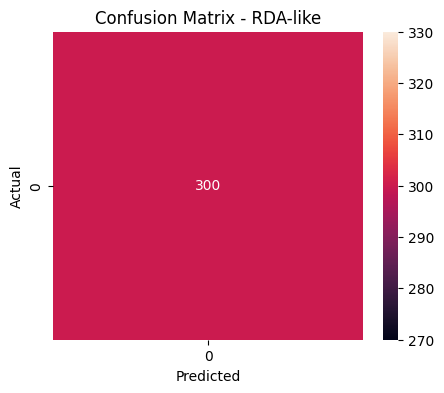

In [28]:
# 10️⃣ Evaluation
print("F1 Score:", f1_score(y_test, y_pred_rda_like))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rda_like))

cm = confusion_matrix(y_test, y_pred_rda_like)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - RDA-like')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()